In [3]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from stepmix.stepmix import StepMix


## Summary of missingness

Let's first look at the state of the training data and see how many missing there are for each target. 

In [87]:
train = pd.read_csv('data/train_data.csv')
train.isna().sum(axis=0)

CXSMILES         0
MDR1-MDCKII      9
LogD            82
KSOL            69
MLM            131
HLM            133
dtype: int64

According to conversations on the discord channel, the missing values are a mix of assays not being run and values being outside of the detection limits. If the assays weren't run then that's a true missing value (although not missing at random), if it's outside the detection limit, we'll try and ascertain which limit it is and put in that value.  Then we can use models which account for censored values to get around this. 

## MDR1-MDCKII

In [70]:
target = 'MDR1-MDCK2'
mdr1mdck2_raw = pd.read_csv(f'raw_data_package/admet/ADMET_{target}_CONFIDENTIAL.csv')
mdr1mdck2_raw = mdr1mdck2_raw.sort_values(by='CXSMILES (CDD Compatible)', inplace=False)
mdr1mdck2_raw = mdr1mdck2_raw.loc[:, ['CXSMILES (CDD Compatible)'] + mdr1mdck2_raw.columns.difference(['CXSMILES (CDD Compatible)']).to_list()]
mdr1mdck2_raw.head()

,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_MDR1-MDCKII-Papp_bienta: SD_Papp_A_to_B (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: SD_Papp_A_to_B (Num),in-vitro_MDR1-MDCKII-Papp_bienta: SD_Papp_B_to_A (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: SD_Papp_B_to_A (Num),in-vitro_MDR1-MDCKII-Papp_bienta: SD_percent_recovery_A_to_B (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: SD_percent_recovery_A_to_B (Num),in-vitro_MDR1-MDCKII-Papp_bienta: SD_percent_recovery_B_to_A (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: SD_percent_recovery_B_to_A (Num),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_B_to_A (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_B_to_A (Num) (10^-6 cm/s),in-vitro_MDR1-MDCKII-Papp_bienta: mean_percent_recovery_A_to_B (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: mean_percent_recovery_A_to_B (Num),in-vitro_MDR1-MDCKII-Papp_bienta: mean_percent_recovery_B_to_A (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: mean_percent_recovery_B_to_A (Num)
656,C#CCCC1=CC=C(OCCCC2=CC(C(=O)N(C)C)=NO2)C=C1,2024-02-26,ASAP-0021070,=,2.707524,NaN,NaN,=,0.620000,NaN,NaN,=,19.30000,NaN,NaN,=,67.900,NaN,NaN
646,C#CCCCCC1=CC=C(OCCCC2=CC(C(=O)N(C)C)=NO2)C=C1,2024-02-19,ASAP-0020904,=,0.577753,NaN,NaN,=,1.050000,NaN,NaN,=,7.87000,NaN,NaN,=,34.600,NaN,NaN
667,C1=CC=C(C2=NC3=NC=NN3C(SC3=NC=CO3)=C2)C=C1,2024-03-25,ASAP-0022831,=,0.008739,=,0.0181113208745472,=,0.422000,=,0.753,=,0.02320,=,0.0391,=,0.588,=,77.287500
25,C1=CC=C(C2=NC3=NC=NN3C(SC3=NN=C(N4CCOCC4)S3)=C...,2024-05-06,ASAP-0027763,=,0.056004,=,"0,0242384203297224",=,2.690000,=,6.870,=,0.14000,=,0.0885,=,11.000,=,83.885584
13,C1=CC=C(C2=NC3=NN=CN3C(SC3=NC(C4=CC=CC=N4)=NO3...,2024-04-22,ASAP-0027553,=,0.003261,=,"0,0342653240272785",=,0.000888,=,0.299,=,0.00854,=,0.0643,=,0.313,=,1.074784


In [46]:
train = train.sort_values(by=['CXSMILES'], inplace=False)

The reported values are the `mean_Papp_A_to_B` - it's not necessary for the the reverse flux to be recorded.  I'm unsure whether this says anything about the process in this case. Let's find the rows in the raw data corresponding to missing values in the training data. 

In [71]:
mdr1mdck2_raw['in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s)'].isna().sum()

0

So there's no missing values in the raw data.  The assays must not have been run. Let's check this by looking at the SMILES:  

In [72]:
raw_smi = set(mdr1mdck2_raw['CXSMILES (CDD Compatible)'].values.tolist())
train_smi = set(train['CXSMILES'].values.tolist())
len(raw_smi - train_smi), len(train_smi - raw_smi)

(0, 9)

In [73]:
mdr1mdck2_not_run = list(train_smi - raw_smi)
mdr1mdck2_not_run

['COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1',
 'CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|',
 'C=CC(=O)N1CCCC2=CC=C(N(C(=O)CC3=CN=CC4=CC=CC=C34)N(C)C3=CC=CC(Cl)=C3)C=C21',
 'O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl',
 'C=CC(=O)N1CCCC2=CC=C(N(CC3=CC=CC(C(F)(F)F)=C3)C(=O)CC3=CN=CC4=CC=CC=C34)C=C21',
 'CC1=NC=CN1C[C@H]1CCC2=C(C1=O)C1=CC=CC=C1N2C |&1:7|',
 'C=CC(=O)N1CCCC2=CC=C(N(CC3=CC=CC(Cl)=C3)C(=O)CC3=CN=CC4=C(F)C=CC=C34)C=C21',
 'NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1',
 'CN(C)CCCN1C2=CC=CC=C2CCC2=CC=CC=C21']

So there are 9 compounds which did not receive a permeability assay. 

## LogD

In [74]:
target = 'LogD'
LogD_raw = pd.read_csv(f'raw_data_package/admet/ADMET_{target}_CONFIDENTIAL.csv')
LogD_raw = LogD_raw.sort_values(by='Molecule Name', inplace=False)
LogD_raw = LogD_raw.loc[:, ['CXSMILES (CDD Compatible)'] + LogD_raw.columns.difference(['CXSMILES (CDD Compatible)']).to_list()]
LogD_raw.head()

,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_LogD_bienta: LogD (Mod),in-vitro_LogD_bienta: LogD (Num)
465,O=C(NC1=CC=CC=C1)NC1=CC=C(C(=O)NC2C3=C(CC2C(=O...,2022-08-07,ASAP-0000132,=,0.12
466,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(B...,2022-08-07,ASAP-0000136,=,0.22
464,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,2022-08-10,ASAP-0000175,=,3.80
463,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,2022-10-03,ASAP-0000272,=,1.07
461,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C...,2022-10-27,ASAP-0000450,=,3.20


Check the 'Mod' symbols to look for censoring: 

In [75]:
LogD_raw['in-vitro_LogD_bienta: LogD (Mod)'].unique()

array(['=', '≤', '≥'], dtype=object)

So there is both left and right censoring going on: 

In [82]:
logd_censored = LogD_raw.loc[LogD_raw['in-vitro_LogD_bienta: LogD (Mod)']!="=", :]
print(logd_censored.shape)
logd_censored.sort_values(by=['CXSMILES (CDD Compatible)'])

(25, 5)


,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_LogD_bienta: LogD (Mod),in-vitro_LogD_bienta: LogD (Num)
173,CC(C)CNC(=O)C1=CC(Cl)=C(F)C=C1NS(=O)(=O)C1=CC=...,2024-01-02,ASAP-0016818,≥,4.5
156,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,2024-01-25,ASAP-0017288,≥,4.5
139,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,2024-02-01,ASAP-0017434,≥,4.5
151,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,2024-01-25,ASAP-0017308,≥,4.5
147,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=CC=N1,2024-01-25,ASAP-0017304,≥,4.5
157,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=CN=C1,2024-01-25,ASAP-0017287,≥,4.5
155,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=NC=C1,2024-01-25,ASAP-0017290,≥,4.5
165,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CN=CO1,2024-01-25,ASAP-0017294,≥,4.5
158,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CON=C1,2024-01-25,ASAP-0017286,≥,4.5
162,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CSN=N1,2024-01-25,ASAP-0017295,≥,4.5


In [83]:
logd_train_censored = train.loc[train['CXSMILES'].isin(logd_censored['CXSMILES (CDD Compatible)'].values.tolist()), :]
print(logd_train_censored.shape)
logd_train_censored.sort_values(by=['CXSMILES'])

(25, 6)


,CXSMILES,MDR1-MDCKII,LogD,KSOL,MLM,HLM
197,CC(C)CNC(=O)C1=CC(Cl)=C(F)C=C1NS(=O)(=O)C1=CC=...,2.3900,NaN,4.0,NaN,198.0
184,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,2.2600,NaN,9.0,24.4,11.0
164,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,0.5420,NaN,12.0,35.7,NaN
191,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC(C(=...,1.6400,NaN,4.0,98.3,18.5
174,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=CC=N1,0.5500,NaN,10.0,31.3,10.7
178,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=CN=C1,0.5780,NaN,7.0,46.2,14.9
183,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CC=NC=C1,0.4680,NaN,4.0,24.0,10.9
180,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CN=CO1,1.5800,NaN,3.0,48.2,10.5
188,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CON=C1,3.0000,NaN,12.0,51.1,NaN
179,CC1=CC(C2=NOC(C(F)(F)F)=N2)=CC=C1OCCCC1=CSN=N1,1.2600,NaN,3.0,109.0,27.5


Double check the smiles are the same

In [84]:
logd_censored_smi = set(logd_censored['CXSMILES (CDD Compatible)'].values.tolist())
logd_train_censored_smi = set(logd_train_censored['CXSMILES'].values.tolist()) 
len(logd_censored_smi - logd_train_censored_smi), len(logd_train_censored_smi - logd_censored_smi)

(0, 0)

This means that there should be 55 molecules that were not run.  Let's get these: 

In [85]:
logd_not_run = set(train['CXSMILES'].values.tolist()) -  set(LogD_raw['CXSMILES (CDD Compatible)'].values.tolist())
len(logd_not_run)

55

## KSOL

In [88]:
ksol_raw = pd.read_csv(f'raw_data_package/admet/ADMET_KSOL_CONFIDENTIAL.csv')
ksol_raw = ksol_raw.sort_values(by='Molecule Name', inplace=False)
ksol_raw = ksol_raw.loc[:, ['CXSMILES (CDD Compatible)'] + ksol_raw.columns.difference(['CXSMILES (CDD Compatible)']).to_list()]
ksol_raw.head()

,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_KSOL-PBS_bienta: SE_solubility (Mod),in-vitro_KSOL-PBS_bienta: SE_solubility (Num),in-vitro_KSOL-PBS_bienta: mean_solubility (Mod),in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM),in-vitro_KSOL-PBS_bienta: pH
215,O=C(NC1=CC=CC=C1)NC1=CC=C(C(=O)NC2C3=C(CC2C(=O...,2022-08-07,ASAP-0000132,NaN,5.2,=,319.0,7.4
214,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(B...,2022-08-07,ASAP-0000136,NaN,NaN,>=,400.0,7.4
216,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,2022-08-10,ASAP-0000175,=,0.7,=,24.7,7.4
217,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,2022-10-03,ASAP-0000272,NaN,NaN,>=,400.0,7.4
213,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C...,2022-10-27,ASAP-0000450,NaN,0.6,=,224.0,7.4


From inspection of the data there may molecules that have been run numerous times.  Let's have a look at these.  

In [101]:
ksol_raw['in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)'].unique()
counts = ksol_raw.groupby('Molecule Name')['in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)'].count()

np.unique(counts.values , return_counts=True)

(array([ 1,  2, 92]), array([403,   6,   1]))

So there are 7 molecules that have more than 1 entry. 

In [108]:
ksol_raw.loc[ksol_raw['Molecule Name'].isin(counts[counts>1].index.to_list()), 'in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)'].unique()

array(['='], dtype=object)

However, all of these have a '=' sign so they probably made it in the final datasets. 

In [109]:
ksol_censored = ksol_raw.loc[ksol_raw['in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)']!='=', :]
print(ksol_censored.shape)
ksol_censored

(45, 8)


,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_KSOL-PBS_bienta: SE_solubility (Mod),in-vitro_KSOL-PBS_bienta: SE_solubility (Num),in-vitro_KSOL-PBS_bienta: mean_solubility (Mod),in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM),in-vitro_KSOL-PBS_bienta: pH
214,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(B...,2022-08-07,ASAP-0000136,NaN,NaN,>=,400.0,7.4
217,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,2022-10-03,ASAP-0000272,NaN,NaN,>=,400.0,7.4
212,CC(C)[C@H](CO)NC1=NC=NC2=C1C=CN2,2022-10-27,ASAP-0000453,NaN,NaN,>=,400.0,7.4
209,COC1=CC=C([C@H](CC(=O)O)NC(=O)C2=NC=NC3=C2C=CN...,2022-12-02,ASAP-0000591,NaN,NaN,>=,400.0,7.4
208,O=C(NC1=C2NC=C(C(=O)N[C@H]3C4=CC=CC=C4C[C@H]3C...,2022-12-02,ASAP-0000627,NaN,NaN,>=,400.0,7.4
160,CC(C)[C@H](NC1=NC=NC(N)=C1Cl)C1=CC=C2CCCS(=O)(...,2023-04-25,ASAP-0010739,NaN,NaN,≥,400.0,7.4
158,COC1=CC=C([C@H](NC(=O)C2=C3C=CNC3=NC=N2)C(C)C2...,2023-04-25,ASAP-0010744,NaN,NaN,≥,400.0,7.4
318,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,2023-05-23,ASAP-0011125,NaN,NaN,≥,400.0,7.4
322,CCNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)...,2023-06-13,ASAP-0011343,NaN,NaN,≥,400.0,7.4
323,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,2023-06-13,ASAP-0011358,NaN,NaN,≥,400.0,7.4


In [92]:
ksol_train_censored = train.loc[train['CXSMILES'].isin(ksol_censored['CXSMILES (CDD Compatible)'].values.tolist()), :]
print(ksol_train_censored.shape)
ksol_train_censored.sort_values(by=['CXSMILES'])

(46, 6)


,CXSMILES,MDR1-MDCKII,LogD,KSOL,MLM,HLM
420,CC(C)[C@H](CO)NC1=NC=NC2=C1C=CN2,13.1000,1.69,NaN,10.0,6.0
358,CC(C)[C@H](NC1=NC=NC(N)=C1Cl)C1=CC=C2CCCS(=O)(...,10.1000,2.40,NaN,204.0,79.0
7,CC1=CC([C@H](NC2=CC=C3CNCC3=C2)C(=O)NCC(F)F)=C...,0.7000,1.00,NaN,NaN,NaN
117,CC1=CC=C(C2=NN=C(SC3=CC(C4=CC=CC=C4)=NC4=NC=NN...,1.8500,4.30,NaN,NaN,NaN
231,CC1=NC=CN1C[C@H](C)CNC(=O)C1=CC=C2COB(O)C2=C1 ...,1.3000,0.20,NaN,12.0,1.0
324,CCNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)...,2.7900,1.50,NaN,232.0,65.0
238,CN(C(=O)C1=CC=C2COB(O)C2=C1)[C@H]1CCN(C2CC2)C1...,12.0000,0.70,NaN,8.0,16.0
241,CN(C)C[C@H]1C[C@H](NC(=O)C2=CC=C3COB(O)C3=C2)C1,0.9000,NaN,NaN,19.0,5.0
276,CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O...,4.2000,1.60,382.0,73.0,53.0
272,CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O...,3.2000,1.60,NaN,51.0,26.0


There are 45 that are censored in the raw data and that are missing in the training data.  The only anomoly is the molecule at index 276.  Let's have a look at this.  

In [122]:
pd.set_option('display.max_colwidth', 0)

ksol_raw.loc[ksol_raw['CXSMILES (CDD Compatible)']==ksol_train_censored.loc[~ksol_train_censored.KSOL.isna(), 'CXSMILES'].values[0], :].T

,105,342
CXSMILES (CDD Compatible),CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|,CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|
Batch Created Date,2023-07-13,2023-07-13
Molecule Name,ASAP-0013308,ASAP-0013309
in-vitro_KSOL-PBS_bienta: SE_solubility (Mod),NaN,=
in-vitro_KSOL-PBS_bienta: SE_solubility (Num),NaN,1.7
in-vitro_KSOL-PBS_bienta: mean_solubility (Mod),≥,=
in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM),400.0,382.0
in-vitro_KSOL-PBS_bienta: pH,7.4,7.4


In [123]:
LogD_raw.loc[LogD_raw['Molecule Name'].isin(['ASAP-0013308', 'ASAP-0013309']),:].T

,245,237
CXSMILES (CDD Compatible),CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|,CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|
Batch Created Date,2023-07-13,2023-07-13
Molecule Name,ASAP-0013308,ASAP-0013309
in-vitro_LogD_bienta: LogD (Mod),=,=
in-vitro_LogD_bienta: LogD (Num),1.6,1.6


In [124]:
mdr1mdck2_raw.loc[mdr1mdck2_raw['Molecule Name'].isin(['ASAP-0013308', 'ASAP-0013309']), 
                  ['CXSMILES (CDD Compatible)', 'Molecule Name', 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod)', 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s)']].T

,142,527
CXSMILES (CDD Compatible),CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|,CN1C=NC(CN2C[C@]3(CCN(C4=CN=CC5=CC=CC=C45)C3=O)C3=CC(Cl)=CC=C3C2=O)=N1 |o1:8|
Molecule Name,ASAP-0013308,ASAP-0013309
in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod),=,=
in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s),3.2,4.2


Let's look at the molecules not run: 

In [126]:
ksol_not_run = set(train['CXSMILES'].values.tolist()) - set(ksol_raw['CXSMILES (CDD Compatible)'].values.tolist())
print(len(ksol_not_run))

24


24 + 45 = 69 which is the number of missing values.  We just need to resolve the problem with ASAP-0013309/8


## MLM

In [187]:
mlm_raw = pd.read_csv(f'raw_data_package/admet/ADMET_MLM_CONFIDENTIAL.csv')
mlm_raw = mlm_raw.sort_values(by='Molecule Name', inplace=False)
mlm_raw = mlm_raw.loc[:, ['CXSMILES (CDD Compatible)'] + mlm_raw.columns.difference(['CXSMILES (CDD Compatible)']).to_list()]
mlm_raw.head()

,CXSMILES (CDD Compatible),Batch Created Date,Molecule Name,in-vitro_MLM_bienta: CLint (Mod),in-vitro_MLM_bienta: CLint (Num) (uL/min/mg),in-vitro_MLM_bienta: percent_remaining (Mod),in-vitro_MLM_bienta: percent_remaining (Num),in-vitro_MLM_bienta: percent_remaining_no_cofactor (Mod),in-vitro_MLM_bienta: percent_remaining_no_cofactor (Num),in-vitro_MLM_bienta: t_half (Mod),in-vitro_MLM_bienta: t_half (Num) (min)
220,O=C(NC1=CC=CC=C1)NC1=CC=C(C(=O)NC2C3=C(CC2C(=O)O)C(O)=CC=C3)C=C1,2022-08-07,ASAP-0000132,=,2.0,=,111.0,=,99.0,=,1070.0
219,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(Br)C=C1 |&1:4|,2022-08-07,ASAP-0000136,=,1.0,=,106.0,=,99.0,=,2960.0
221,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=CN=CC3=CC=CC=C23)=C1,2022-08-10,ASAP-0000175,=,2380.0,=,0.0,=,86.0,=,0.7
222,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C[C@@H]2C)C2=C(C=CC(F)=C2)C1=O,2022-10-03,ASAP-0000272,=,23.0,=,74.0,=,99.0,=,73.6
218,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C1 |&1:3|,2022-10-27,ASAP-0000450,=,340.0,=,0.0,=,103.0,=,4.9


In [188]:
mlm_not_run = set(train['CXSMILES'].values.tolist()) - set(mlm_raw['CXSMILES (CDD Compatible)'].values.tolist())
len(mlm_not_run)

99

So there are  99 molecules without a MLM assay. We need to find 32 censored/missing values in the raw data. 

In [190]:
np.unique(mlm_raw['in-vitro_MLM_bienta: CLint (Mod)'].values, return_counts=True)

(array(['<', '='], dtype=object), array([ 22, 538]))

In [136]:
mlm_raw.loc[:, ['in-vitro_MLM_bienta: CLint (Mod)', 'in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)']].isna().sum()

in-vitro_MLM_bienta: CLint (Mod)                0 
in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)    12
dtype: int64

22 + 12 = 34.  These must add up to 31.  There must be some overlap: 

In [202]:
mlm_missing_or_censored = mlm_raw.loc[(mlm_raw['in-vitro_MLM_bienta: CLint (Mod)']=='<') | (mlm_raw['in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)'].isna()), :]
mlm_missing_or_censored.shape

(34, 11)

In [191]:
mlm_missing_and_censored = mlm_raw.loc[(mlm_raw['in-vitro_MLM_bienta: CLint (Mod)']=='<') & (mlm_raw['in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)'].isna()), :]
mlm_missing_and_censored.shape

(0, 11)

In [199]:
len(set(mlm_missing_or_censored['CXSMILES (CDD Compatible)'].values.tolist())), len(set(mlm_missing_or_censored['Molecule Name'].values.tolist()))

(33, 34)

So amongst the censored data there is one molecule with two molecule names: 

In [200]:
ix = mlm_missing_or_censored.groupby('CXSMILES (CDD Compatible)')['Molecule Name'].count()
np.unique(ix, return_counts=True)

mlm_missing_or_censored.loc[mlm_missing_or_censored['CXSMILES (CDD Compatible)'].isin(ix[ix>1].index.to_list())].T


,73,74
CXSMILES (CDD Compatible),O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Cl)=CC(C2CC2)=C1 |o1:7|,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Cl)=CC(C2CC2)=C1 |o1:7|
Batch Created Date,2024-08-12,2024-08-12
Molecule Name,ASAP-0030775,ASAP-0030776
in-vitro_MLM_bienta: CLint (Mod),<,<
in-vitro_MLM_bienta: CLint (Num) (uL/min/mg),10.0,10.0
in-vitro_MLM_bienta: percent_remaining (Mod),=,=
in-vitro_MLM_bienta: percent_remaining (Num),93.18413,90.621814
in-vitro_MLM_bienta: percent_remaining_no_cofactor (Mod),=,=
in-vitro_MLM_bienta: percent_remaining_no_cofactor (Num),99.155085,90.232263
in-vitro_MLM_bienta: t_half (Mod),>,>


As it is left censored, that is fine.   Are any of these censored values in the training data: 

In [201]:
mlm_missing_or_censored_smi = set(mlm_missing_or_censored['CXSMILES (CDD Compatible)'].values.tolist())
train.loc[(train['CXSMILES'].isin(list(mlm_missing_or_censored_smi))) & (~train['MLM'].isna()), :]

,CXSMILES,MDR1-MDCKII,LogD,KSOL,MLM,HLM
428,CN(C)CCCN1C2=CC=CC=C2CCC2=CC=CC=C21,NaN,NaN,NaN,169.0,NaN
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,NaN,NaN,NaN,63.0,25.5


In [ ]:
mlm_raw.loc[mlm_raw['CXSMILES (CDD Compatible)'].isin(['CN(C)CCCN1C2=CC=CC=C2CCC2=CC=CC=C21', 'CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|']), 'in-vitro_MLM_bienta: CLint (Mod)']

array(['='], dtype=object)

OK, this is getting complicated - I'm moving to a new notebook. 

# Number of missing

In [42]:
df = train.as_dataframe()
for col in df.columns.difference(['CXSMILES']): 
    df[f'isna-{col}'] = df[col].isna()

for i in [3, 4, 5, 6, 7]:
    model = StepMix(n_components=i, measurement='binary', verbose=0, random_state=42)
    model.fit(df.filter(regex='^isna'))


    df[f'class_n{i}'] = model.predict(df.filter(regex='^isna'))
# sk.cluster.KMeans()

# sns.heatmap(y_vals.isna(),  square=False, cbar=False)

/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 31.00it/s, max_LL=-843, max_avg_LL=-1.94]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.87it/s, max_LL=-838, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, max_LL=-836, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, max_LL=-836, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, max_LL=-833, max_avg_LL=-1.92]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

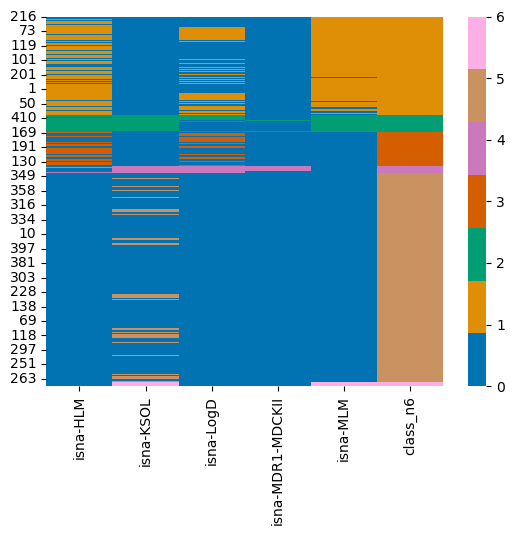

In [85]:
n_clusters = 6
ccol = f"class_n{n_clusters}"
to_plot = df.filter(regex=f'(^isna)|({ccol})').copy()

to_plot = to_plot.sort_values(by=ccol, ascending=True)
to_plot[ccol] += 1

for col in to_plot.columns.difference([ccol]):
    to_plot[col] = to_plot.apply(lambda x: {True: x[ccol],False: 0}[x[col]], axis=1)



sns.heatmap(to_plot, cmap=sns.color_palette('colorblind', n_clusters+1),  square=False, cbar=True)

In [6]:
df = train.as_dataframe()

n_missing_per_mol = df[df.columns.difference(['CXSMILES'])].isna().sum(axis=1)

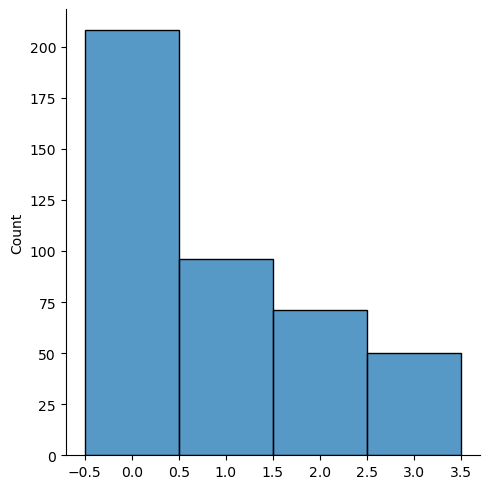

In [7]:
sns.displot(n_missing_per_mol, bins=np.array([0, 1, 2, 3, 4])-0.5)

# Predicting the missing
Given the very different scales of the end points, and the fact that LogD is on a log scale, it makes sense to scale the inputs and apply a log+1 transform. Then we can use the values as predictors for the missing values. 

In [14]:
min_val, max_val = np.exp(df.LogD.min()), np.exp(df.LogD.max())
min_val, max_val

(0.4965853037914095, 90.01713130052181)

Init signature:
sk.preprocessing.MinMaxScaler(
    feature_range=(0, 1),
    *,
    copy=True,
    clip=False,
)
Docstring:     
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

The transformation is given by::

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

This transformation is often used as an alternative to zero mean,
unit variance scaling.

`MinMaxScaler` doesn't reduce the effect of outliers, but it linearly
scales them down into a fixed range, where the largest occurring data point
corresponds to the maximum value and the smallest one corresponds to the
minimum value. For an example visualization, refer to :ref:`Compare
MinMaxScaler with other scalers <plot_all_scaling_minmax_scaler_section>`.

Read more in the :ref:`User Guide 

In [1]:
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer